In [1]:
# Github link: https://github.com/sreksoz/Intro-to-Machine-Learning/tree/HW-6--Sensors-And-Decoders
import numpy as np
from processdata import load_data, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Randomly select 3 sensor locations 
num_sensors = 3 

# Set the trajectory length (lags) to 52, corresponding to one year of measurements.
lags = 52
 
# Load the data
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

In [3]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

In [4]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

In [5]:
### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [6]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=30, lr=1e-3, verbose=True, patience=5)

epoch: 20 valid_error: tensor(0.2283): 100%|████| 30/30 [01:15<00:00,  2.51s/it]


In [7]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.039674558


In [8]:
from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

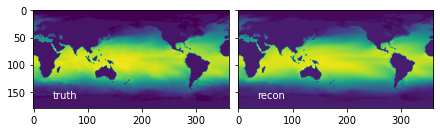

In [9]:
plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

In [10]:
import time

# Define time lag values to test
time_lag_values = [1, 10, 28, 34, 47, 52, 65, 78, 84, 99]  # Set the desired time lag values

results = []
test_recon_vals = []

for lags in time_lag_values:

    start_time = time.time()
        
    # Prepare SHRED dataset
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
        
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
        
    # Train SHRED on dataset
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=30, lr=1e-3, verbose=True, patience=5)
        
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
        
    # Calculate the loss
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    percent_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        
    # Store the results
    results.append((lags, percent_error, elapsed_time))
    
    # Store reconstructed test values
    test_recon_vals.append(test_recons)


epoch: 20 valid_error: tensor(0.2251): 100%|████| 30/30 [01:14<00:00,  2.48s/it]


In [11]:
# Print the results
for result in results:
    lags, percent_error, elapsed_time = result
    print(f"Time Lag: {lags}, Loss: {percent_error}, Elapsed Time: {elapsed_time}")

Time Lag: 1, Loss: 0.0475803017616272, Elapsed Time: 64.11505222320557
Time Lag: 10, Loss: 0.04034581035375595, Elapsed Time: 62.974735736846924
Time Lag: 28, Loss: 0.04035485163331032, Elapsed Time: 64.7619400024414
Time Lag: 34, Loss: 0.04028468206524849, Elapsed Time: 63.97046995162964
Time Lag: 47, Loss: 0.040331803262233734, Elapsed Time: 67.04755806922913
Time Lag: 52, Loss: 0.039287783205509186, Elapsed Time: 70.53368306159973
Time Lag: 65, Loss: 0.03958641737699509, Elapsed Time: 71.29558181762695
Time Lag: 78, Loss: 0.03905293717980385, Elapsed Time: 73.6594910621643
Time Lag: 84, Loss: 0.039425019174814224, Elapsed Time: 71.60625791549683
Time Lag: 99, Loss: 0.03925091773271561, Elapsed Time: 75.26624894142151


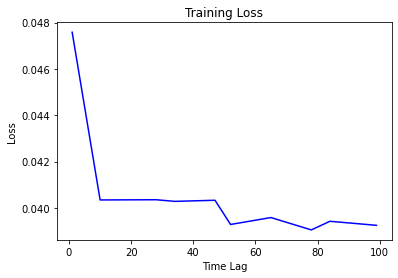

In [12]:
loss = []

for result in results:
    lags, percent_error, elapsed_time = result
    loss.append(percent_error)

plt.plot(time_lag_values, loss, 'b', label='Loss')
plt.title('Training Loss')
plt.xlabel('Time Lag')
plt.ylabel('Loss')
plt.show()

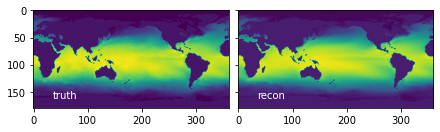

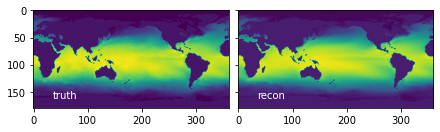

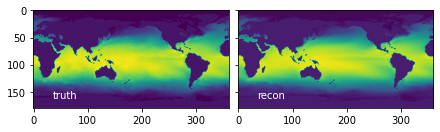

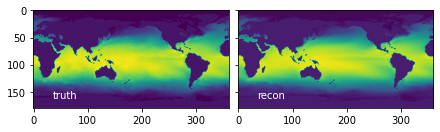

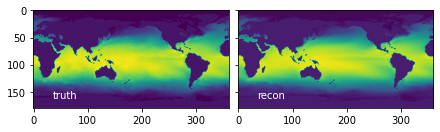

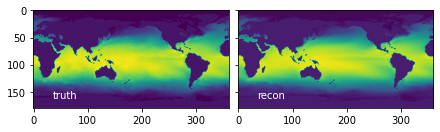

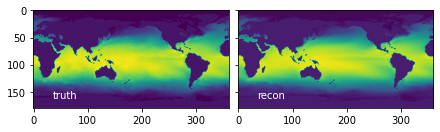

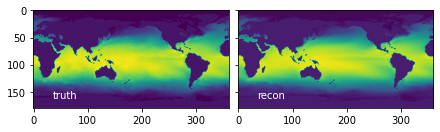

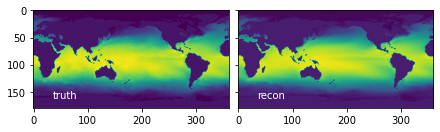

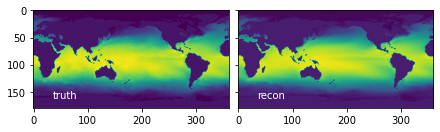

In [13]:
from processdata import load_full_SST

for test_recon in test_recon_vals:
    
    # SST data with world map indices for plotting
    full_SST, sst_locs = load_full_SST()
    full_test_truth = full_SST[test_indices, :]

    # replacing SST data with our reconstruction
    full_test_recon = full_test_truth.copy()
    full_test_recon[:,sst_locs] = test_recons

    # reshaping to 2d frames
    for x in [full_test_truth, full_test_recon]:
        x.resize(len(x),180,360)

    plotdata = [full_test_truth, full_test_recon]
    labels = ['truth','recon']
    fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
    for axis,p,label in zip(ax, plotdata, labels):
        axis.imshow(p[0])
        axis.set_aspect('equal')
        axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)



In [5]:
# Define variables of number of sensors to test
num_sensors = [3, 5, 9, 15, 20, 55, 67, 80, 100]  # Set the desired number of sensors to test
lags = 52

results = []
test_recon_vals =[]


for num_sensors in num_sensors:
    
    # Set value for sensor locations
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)
        
    # Prepare SHRED dataset
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
        
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
        
    # Train SHRED on dataset
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=30, lr=1e-3, verbose=True, patience=5)
    
        
    # Calculate the loss
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    percent_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        
    # Store the results
    results.append((num_sensors, percent_error))
    
    # Store reconstructed test values
    test_recon_vals.append(test_recons)

epoch: 20 valid_error: tensor(0.1943): 100%|████| 30/30 [01:09<00:00,  2.31s/it]


In [8]:
# Print the results
for result in results:
    num_sensors, percent_error = result
    print(f"Number of Sensors: {num_sensors}, Loss: {percent_error}")

Number of Sensors: 3, Loss: 0.04003076255321503
Number of Sensors: 5, Loss: 0.0393928587436676
Number of Sensors: 9, Loss: 0.03953132778406143
Number of Sensors: 15, Loss: 0.038426756858825684
Number of Sensors: 20, Loss: 0.037728726863861084
Number of Sensors: 55, Loss: 0.036844830960035324
Number of Sensors: 67, Loss: 0.035911086946725845
Number of Sensors: 80, Loss: 0.0360005684196949
Number of Sensors: 100, Loss: 0.036530159413814545


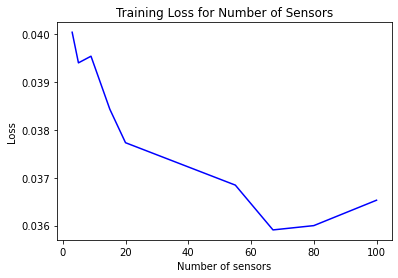

In [9]:
num_sensors_vals = [3, 5, 9, 15, 20, 55, 67, 80, 100]
loss = []

for result in results:
    num_sensors, percent_error = result
    loss.append(percent_error)


plt.plot(num_sensors_vals, loss, 'b', label='Loss')
plt.title('Training Loss for Number of Sensors')
plt.xlabel('Number of sensors')
plt.ylabel('Loss')
plt.show()

In [5]:
# Add Gaussian noise function
def add_gaussian_noise(data, mean, std_dev):
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise
    return noisy_data

# Reset initial parameters
num_sensors = 3
lags = 52
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Specify the range of noise (standard deviation) levels 
mean = 0  # Mean of the Gaussian noise

results = []
test_recon_vals =[]


for noise_level in noise_levels:
        
    # Prepare SHRED dataset
    train_indices = np.random.choice(n - lags, size=1000, replace=False)
    mask = np.ones(n - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[::2]
    test_indices = valid_test_indices[1::2]
        
    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]
    
    # Add Gaussian noise to data
    noisy_train_data = add_gaussian_noise(all_data_in, mean, std_dev=noise_level)

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(noisy_train_data[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(noisy_train_data[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(noisy_train_data[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
        
    # Train SHRED on dataset
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=30, lr=1e-3, verbose=True, patience=5)
    
        
    # Calculate the loss
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    percent_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        
    # Store the results
    results.append((noise_level, percent_error))
    
    # Store reconstructed test values
    test_recon_vals.append(test_recons)

epoch: 20 valid_error: tensor(0.2777): 100%|████| 30/30 [01:06<00:00,  2.23s/it]


In [6]:
# Print the results
for result in results:
    noise_level, percent_error = result
    print(f"Noise Level: {noise_level}, Loss: {percent_error}")

Noise Level: 0, Loss: 0.03966614976525307
Noise Level: 0.1, Loss: 0.039365384727716446
Noise Level: 0.2, Loss: 0.04000096395611763
Noise Level: 0.3, Loss: 0.041575949639081955
Noise Level: 0.4, Loss: 0.043216098099946976
Noise Level: 0.5, Loss: 0.045950569212436676
Noise Level: 0.6, Loss: 0.050347115844488144
Noise Level: 0.7, Loss: 0.055492185056209564
Noise Level: 0.8, Loss: 0.05406790226697922
Noise Level: 0.9, Loss: 0.05937511846423149


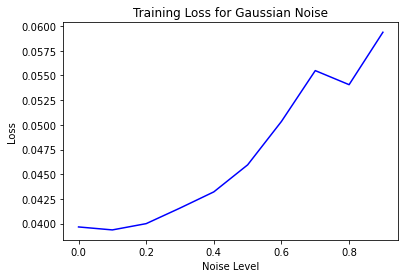

In [7]:
loss = []

for result in results:
    noise_level, percent_error = result
    loss.append(percent_error)


plt.plot(noise_levels, loss, 'b', label='Loss')
plt.title('Training Loss for Gaussian Noise')
plt.xlabel('Noise Level')
plt.ylabel('Loss')
plt.show()